In [549]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import re
import os
import shap
import string
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pouri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Functions

In [572]:
# Utility function to load data
def load_tabular_data(filepath, sheet, columns=None):
    df = pd.read_excel(filepath, sheet_name=sheet)
    if columns:
        df = df[columns]
    return df

In [573]:
# Join transcripts based on PID linkage with underscore
def join_transcripts(df_all, transcript_dir):
    df_all = df_all.copy()
    texts = []
    transcript_files = os.listdir(transcript_dir)
    for pid in df_all['VisitorID']:
        transcript_found = False
        pid_pattern = re.compile(rf'.*[_]{pid}[_]?.*|.*[_]?{pid}[_].*')
        for filename in transcript_files:
            if pid_pattern.match(filename):
                file_path = os.path.join(transcript_dir, filename)
                with open(file_path, 'r', encoding='utf-8') as file:
                    texts.append(file.read())
                transcript_found = True
                break
        if not transcript_found:
            texts.append('')  # Handle missing files
    df_all['transcript'] = texts
    return df_all

In [574]:
# Merge patient data with tabular data on PID and Study ID
def merge_patient_data(tabular_df, patient_df, tabular_pid_col='PID', patient_pid_col='Study ID'):
    merged_df = pd.merge(tabular_df, patient_df, left_on=tabular_pid_col, right_on=patient_pid_col, how='inner')
    return merged_df

In [575]:
# Data Preparation based on different scenarios
def prepare_data_scenario(df, target_col, text_columns=['transcript'], categorical_columns=['Question', 'Answer', 'Sex']):
    df = df.dropna(subset=[target_col])

    # Ensure text columns are strings
    text_data = df[text_columns].fillna('').astype(str)

    # Convert boolean columns in categorical to strings (important for get_dummies to work)
    for col in categorical_columns:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(str)

    # Encode categorical columns
    categorical_data = pd.get_dummies(df[categorical_columns], drop_first=True)

    # Drop unused columns and select numeric
    exclude_cols = ['PID', 'finaldx', 'VisitorID', 'Study ID', target_col] + text_columns + categorical_columns
    numerical_data = df.drop(columns=exclude_cols, errors='ignore').select_dtypes(include=['number'])

    # Combine everything
    tabular_data = pd.concat([numerical_data, categorical_data], axis=1)
    X = pd.concat([text_data, tabular_data], axis=1)
    y = df[target_col]

    return X, y


In [576]:
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def clean_text(self, text):
        text = str(text).lower()
        text = re.sub(r'[\d]+', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        return ' '.join(tokens)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if isinstance(X, pd.Series):
            return X.apply(self.clean_text)
        elif isinstance(X, pd.DataFrame):
            return X.iloc[:, 0].apply(self.clean_text)
        elif isinstance(X, np.ndarray):
            return pd.Series(X.ravel()).apply(self.clean_text)
        else:
            raise ValueError("Unsupported input type for TextCleaner")


In [577]:
class Doc2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, window=5, min_count=2, workers=4, epochs=40, dm=1):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.epochs = epochs
        self.dm = dm

    def fit(self, X, y=None):
        # Tag each document with a unique ID
        tagged_data = [TaggedDocument(words=str(doc).split(), tags=[i]) for i, doc in enumerate(X)]
        self.model = Doc2Vec(vector_size=self.vector_size,
                             window=self.window,
                             min_count=self.min_count,
                             workers=self.workers,
                             dm=self.dm)
        self.model.build_vocab(tagged_data)
        self.model.train(tagged_data,
                         total_examples=self.model.corpus_count,
                         epochs=self.epochs)
        return self

    def transform(self, X, y=None):
        return np.array([self.model.infer_vector(str(doc).split()) for doc in X])

In [578]:
class ColumnSelector:
    def __init__(self, columns=None, dtype_include=None, dtype_exclude=None):
        self.columns = columns
        self.dtype_include = dtype_include
        self.dtype_exclude = dtype_exclude

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.columns:
            return X[self.columns].values.ravel()
        elif self.dtype_include:
            return X.select_dtypes(include=self.dtype_include)
        elif self.dtype_exclude:
            return X.select_dtypes(exclude=self.dtype_exclude)
        return X

In [579]:
# Feature processing pipeline
def build_pipeline(use_text=True, use_tabular=True, model=RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')):
    steps = []

    if use_text:
        steps.append(('text', Pipeline([
            ('selector', ColumnSelector(columns=['transcript'])),
            ('cleaner', TextCleaner()),
            ('tfidf', TfidfVectorizer(max_features=200, min_df=2))
            # ('doc2vec', Doc2VecVectorizer(vector_size=100))
        ])))

    if use_tabular:
        steps.append(('tabular', Pipeline([
            ('selector', ColumnSelector(dtype_include='number')),
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', MinMaxScaler())
        ])))

    features_union = FeatureUnion(steps)

    if isinstance(model, (BalancedRandomForestClassifier, EasyEnsembleClassifier)):
        pipeline = Pipeline([
            ('features', features_union),
            ('clf', model)
        ])
    else:
        pipeline = ImbPipeline([
            ('features', features_union),
            ('smote', SMOTE(random_state=42)),
            ('clf', model)
        ])

    return pipeline

In [580]:
# Explainability analysis
################ For Random Forest #######################
def get_feature_index_mapping(pipeline, X_original):
    feature_union = pipeline.named_steps['features']
    transformers = dict(feature_union.transformer_list)

    feature_names = []

    # --- 1. Text Features (TF-IDF) ---
    if 'text' in transformers:
        text_pipeline = transformers['text']
        tfidf = text_pipeline.named_steps['tfidf']
        tfidf_features = tfidf.get_feature_names_out().tolist()
        feature_names.extend(tfidf_features)

    # --- 2. Tabular Features (after selector) ---
    if 'tabular' in transformers:
        tabular_pipeline = transformers['tabular']
        selector = tabular_pipeline.named_steps['selector']
        tabular_selected = selector.transform(X_original)

        if isinstance(tabular_selected, pd.DataFrame):
            tabular_feature_names = tabular_selected.columns.tolist()
        else:
            tabular_feature_names = [f"tabular_{i}" for i in range(tabular_selected.shape[1])]

        feature_names.extend(tabular_feature_names)

    # Return aligned (f0, name) list
    return [(f"f{i}", name) for i, name in enumerate(feature_names)]


def explain_model_tree(pipeline, X_test):
    import scipy.sparse

    # Transform the input features using the pipeline
    X_transformed = pipeline.named_steps['features'].transform(X_test)

    # Convert to dense if sparse
    if scipy.sparse.issparse(X_transformed):
        X_transformed = X_transformed.toarray()

    X_transformed = X_transformed.astype(float)

    # Get the trained classifier
    clf = pipeline.named_steps['clf']

    # Use TreeExplainer for RandomForest
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_transformed)

    if 'tfidf' in pipeline.named_steps['features']['text'].named_steps.keys():
        feature_map = get_feature_index_mapping(pipeline, X_test)
        feature_names = [name for _, name in feature_map]

        # Ensure number of features matches
        assert X_transformed.shape[1] == len(feature_names), \
            f"Mismatch: {X_transformed.shape[1]} features but {len(feature_names)} names"

        if isinstance(shap_values, list):
            shap_values_to_plot = shap_values[1]  # class 1 (positive class)
        else:
            shap_values_to_plot = shap_values
    elif 'doc2vec' in pipeline.named_steps['features']['text'].named_steps.keys():
        feature_names = [f"d{i}" for i in range(X_transformed.shape[1])]

    shap.summary_plot(shap_values_to_plot, X_transformed, feature_names=feature_names)


############### For Logistic Regression #######################
def explain_model_log(pipeline, X_test):
    import scipy.sparse

    # Transform the input
    X_transformed = pipeline.named_steps['features'].transform(X_test)

    # Convert to dense if sparse
    if scipy.sparse.issparse(X_transformed):
        X_transformed = X_transformed.toarray()

    # Make sure it's float
    X_transformed = X_transformed.astype(float)

    # Use SHAP's LinearExplainer
    clf = pipeline.named_steps['clf']
    explainer = shap.LinearExplainer(clf, X_transformed, feature_perturbation="interventional")
    
    # Compute SHAP values
    shap_values = explainer.shap_values(X_transformed)

    # Feature names
    if 'tfidf' in pipeline.named_steps['features']['text'].named_steps.keys():
        feature_map = get_feature_index_mapping(pipeline, X_test)
        feature_names = [name for _, name in feature_map]

        # Ensure number of features matches
        assert X_transformed.shape[1] == len(feature_names), \
            f"Mismatch: {X_transformed.shape[1]} features but {len(feature_names)} names"

        if isinstance(shap_values, list):
            shap_values_to_plot = shap_values[1]  # class 1 (positive class)
        else:
            shap_values_to_plot = shap_values
    elif 'doc2vec' in pipeline.named_steps['features']['text'].named_steps.keys():
        feature_names = [f"d{i}" for i in range(X_transformed.shape[1])]
        
    shap.summary_plot(shap_values_to_plot, X_transformed, feature_names=feature_names)
    
    
    
def explain_model(pipeline, X_test):
    # Explainability
    if 'RandomForestClassifier' in pipeline.named_steps['clf'].__str__():
        explain_model_tree(pipeline, X_test)
    elif 'LogisticRegression' in pipeline.named_steps['clf'].__str__():
        explain_model_log(pipeline, X_test)


### Main

In [581]:
# Load data
tabular_data = load_tabular_data("data/01. OCI Chest pain study - CRF, Outcomes, Intervention data.xlsx", "CRFDx", columns=['PID', 'finaldx'])
patient_input = load_tabular_data("data/02. OCI Chest Pain - Patient self-input data.xlsx", "CP", columns=['VisitorID', 'Study ID', 'Age', 'Sex\\Gender', 'Question', 'Answer'])
patient_input.rename(columns={'Sex\\Gender': 'Sex'}, inplace=True)
patient_input['Sex'] = patient_input['Sex'].str.split("\\").str[0]
patient_input = patient_input[patient_input['Question'] == 'Do you think that you are suffering a heart attack?']

In [582]:
merged_data = merge_patient_data(tabular_data, patient_input)

In [583]:
# Scenario Example: Using Final Diagnostic binary target (1,2 vs 4,5,6,7)
merged_data['target'] = merged_data['finaldx'].apply(lambda x: 0 if x in [1,2,3] else (1 if x in [4,5,6,7] else None))

# Drop rows with Final Diagnostic value 3
merged_data = merged_data.dropna(subset=['target'])


In [584]:
# Join transcripts
data_with_text = join_transcripts(merged_data, 'data/00. Recordings')

In [585]:
data_with_text

,PID,finaldx,VisitorID,Study ID,Age,Sex,Question,Answer,target,transcript
0,500-0641,5.0,6250,500-0641,54.0,Female,Do you think that you are suffering a heart at...,TRUE,1.0,"What's up? Can I leave this here? Yeah, sure. ..."
1,500-0582,5.0,6105,500-0582,41.0,Male,Do you think that you are suffering a heart at...,FALSE,1.0,"Here and record everything and if you need, if..."
2,500-0556,5.0,6020,500-0556,40.0,Female,Do you think that you are suffering a heart at...,FALSE,1.0,"Hi, my name is Taylor. I'm one of the student ..."
3,400-0004,4.0,3479,400-0004,NaN,NaN,Do you think that you are suffering a heart at...,TRUE,1.0,I think we could have your conversations once ...
4,500-0499,5.0,5893,500-0499,53.0,Female,Do you think that you are suffering a heart at...,FALSE,1.0,"OK, you got to listen. OK. So I'm Megan. I'm o..."
...,...,...,...,...,...,...,...,...,...,...
174,500-0031,5.0,3617,500-0031,22.0,Female,Do you think that you are suffering a heart at...,FALSE,1.0,It's been going on for like 2 years. I origina...
176,500-0033,6.0,3627,500-0033,39.0,Female,Do you think that you are suffering a heart at...,FALSE,1.0,Tight tightness. Tightness. Yeah. And it shoot...
177,500-0047,4.0,3697,500-0047,59.0,Male,Do you think that you are suffering a heart at...,FALSE,1.0,My quite quite a few trips on Yeah. Yeah. Well...
178,500-0044,2.0,3688,500-0044,79.0,Male,Do you think that you are suffering a heart at...,TRUE,0.0,"No, yeah, I had a doctor lady, lady. He called..."


In [587]:
rare_cases = data_with_text[data_with_text['target'] == 0]
augmented = pd.concat([rare_cases] * 4, ignore_index=True)
data_balanced = pd.concat([data_with_text, augmented], ignore_index=True)


In [589]:
# Prepare data
X, y = prepare_data_scenario(data_balanced, 'target')

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [590]:
y_train.value_counts(), y_test.value_counts()

(target
 1.0    132
 0.0     52
 Name: count, dtype: int64,
 target
 1.0    34
 0.0    13
 Name: count, dtype: int64)

In [591]:
# Build and fit model
# model = RandomForestClassifier(n_estimators=50, max_depth=2, min_samples_split=4, min_samples_leaf=5, max_features='sqrt', bootstrap=True, random_state=42)
# model = BalancedRandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
# model = EasyEnsembleClassifier(n_estimators=50, random_state=42)
model = LogisticRegression(max_iter=1000)
# model = DecisionTreeClassifier(max_depth=10, min_samples_split=20, min_samples_leaf=10, random_state=42)
# model = MultinomialNB()
pipeline = build_pipeline(use_text=True, use_tabular=True, model=model)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('selector',
                                                                  <__main__.ColumnSelector object at 0x000001E3CBB4C4A0>),
                                                                 ('cleaner',
                                                                  TextCleaner()),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_features=200,
                                                                                  min_df=2))])),
                                                ('tabular',
                                                 Pipeline(steps=[('selector',
                                                                  <__main__.ColumnSelector object at 0x000001E3CB846210>),
                                                                 ('imputer',
                                                                  SimpleImputer(strategy='median')),
                                                                 ('scaler',
                                                                  MinMaxScaler())]))])),
                ('smote', SMOTE(random_state=42)),
                ('clf', LogisticRegression(max_iter=1000))])

In [592]:
pipeline.score(X_train, y_train)

0.9239130434782609

In [593]:
# Evaluate
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93        13
         1.0       1.00      0.94      0.97        34

    accuracy                           0.96        47
   macro avg       0.93      0.97      0.95        47
weighted avg       0.96      0.96      0.96        47



In [594]:
probs = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]

print(f"Best threshold: {optimal_threshold:.3f}")
y_pred_adjusted = (probs >= optimal_threshold).astype(int)

print(confusion_matrix(y_test, y_pred_adjusted))
print(classification_report(y_test, y_pred_adjusted, digits=2))

Best threshold: 0.418
[[13  0]
 [ 0 34]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        13
         1.0       1.00      1.00      1.00        34

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47



### Visualization

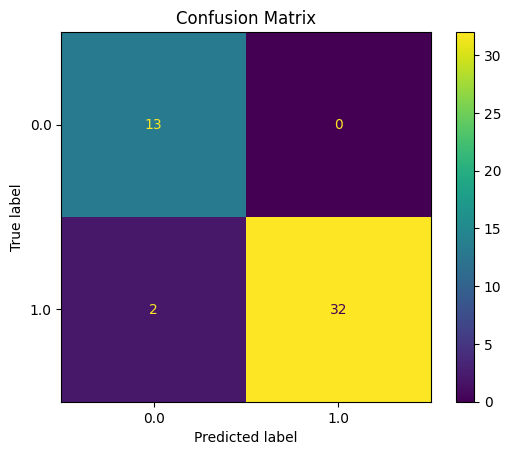

In [595]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()

c:\Users\pouri\Python\Lang_Chain\Projects\Chest_Project\myenv\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


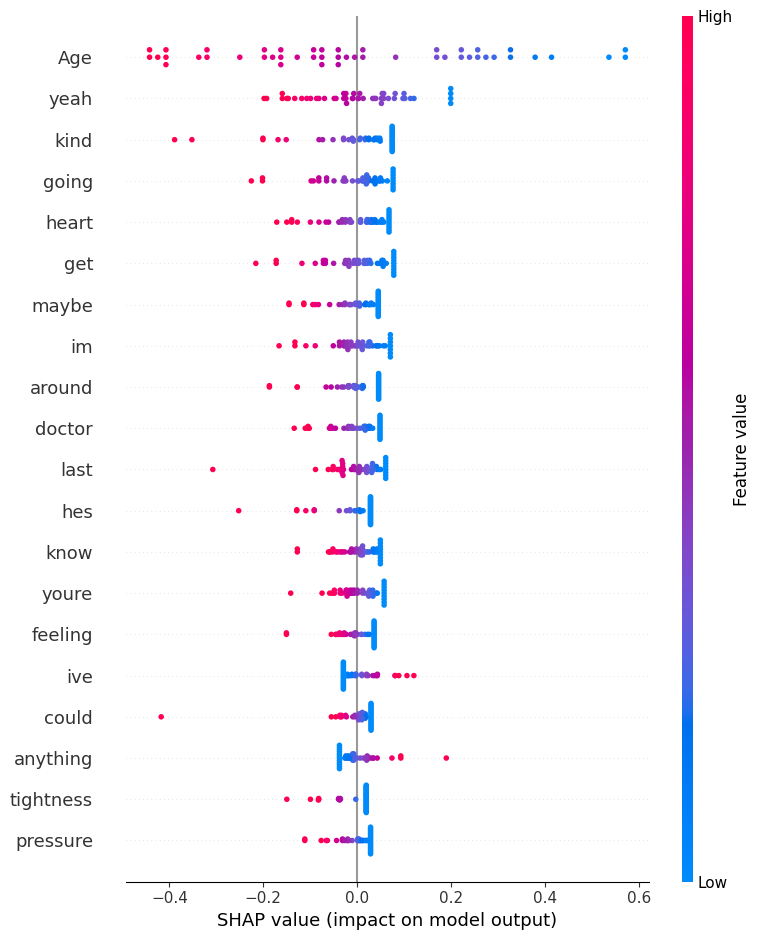

In [596]:
explain_model(pipeline, X_test)

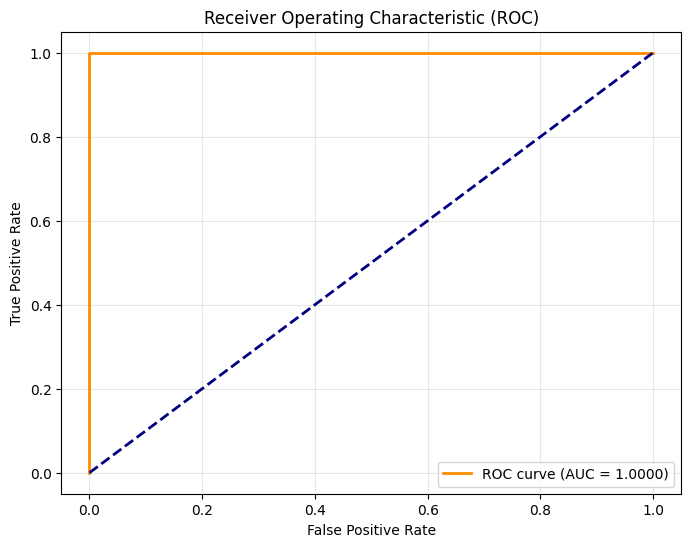

In [597]:
# Predict probabilities (only for the positive class)
y_scores = pipeline.predict_proba(X_test)[:, 1]  # Probability of class 1

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate AUC
roc_auc = roc_auc_score(y_test, y_scores)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


##### Doc2Vec Embedding plot

In [72]:
# # Extract the Doc2Vec pipeline
# text_pipeline = pipeline.named_steps['features'].transformer_list[0][1]
# doc2vec_model = text_pipeline.named_steps['doc2vec']

# # Clean and vectorize your text again (only the 'transcript' column)
# X_text = X_test['transcript'] if isinstance(X_test, pd.DataFrame) else X_test
# X_clean = text_pipeline.named_steps['cleaner'].transform(X_text)

# # Vectorize
# doc2vec_vectors = doc2vec_model.transform(X_clean)

# umap_model = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
# embedding = umap_model.fit_transform(doc2vec_vectors)

# plt.figure(figsize=(10, 7))
# sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=y_test, palette='coolwarm', alpha=0.8)
# plt.title("Doc2Vec Transcript Embeddings (UMAP)")
# plt.xlabel("Component 1")
# plt.ylabel("Component 2")
# plt.legend(title='Target')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


### Other Scenarios

In [ ]:
# Scenario comparison (without text)
pipeline_tabular_only = build_pipeline(use_text=False, use_tabular=True, model=model)
pipeline_tabular_only.fit(X_train, y_train)
y_pred_tabular = pipeline_tabular_only.predict(X_test)
print("Performance without text:")
print(classification_report(y_test, y_pred_tabular))

Performance without text:
              precision    recall  f1-score   support

         0.0       0.53      0.69      0.60        13
         1.0       0.87      0.76      0.81        34

    accuracy                           0.74        47
   macro avg       0.70      0.73      0.71        47
weighted avg       0.77      0.74      0.75        47



In [599]:
# Scenario comparison (just text)
pipeline_text_only = build_pipeline(use_text=True, use_tabular=False, model=model)
pipeline_text_only.fit(X_train, y_train)
y_pred_text = pipeline_text_only.predict(X_test)
print("Performance with only text:")
print(classification_report(y_test, y_pred_text))

Performance with only text:
              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93        13
         1.0       1.00      0.94      0.97        34

    accuracy                           0.96        47
   macro avg       0.93      0.97      0.95        47
weighted avg       0.96      0.96      0.96        47



c:\Users\pouri\Python\Lang_Chain\Projects\Chest_Project\myenv\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


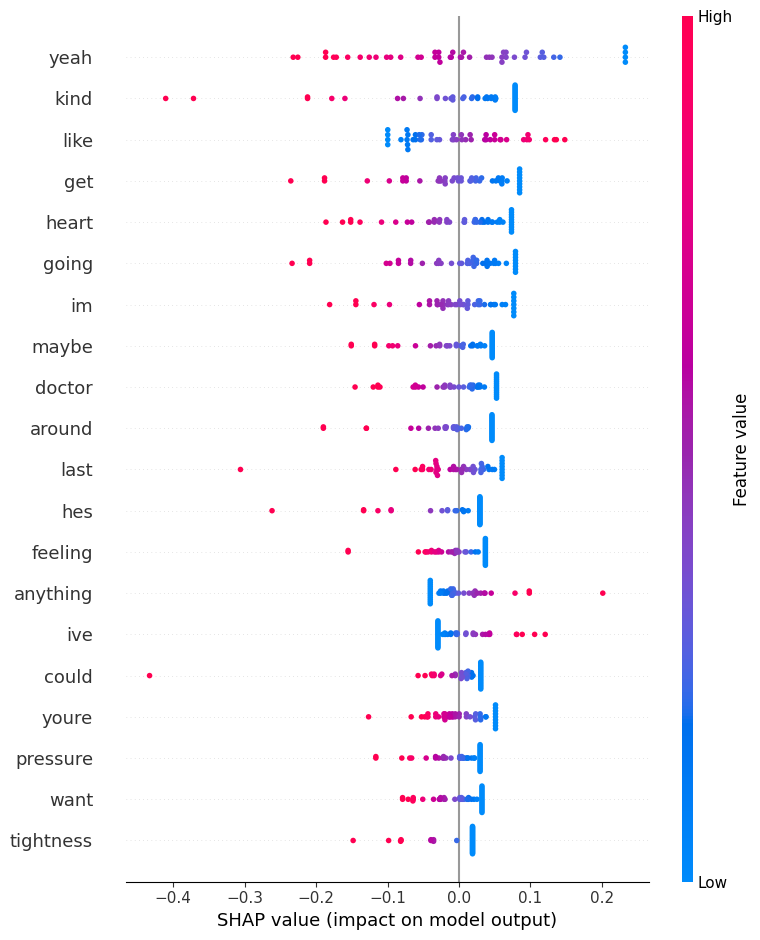

In [600]:
explain_model(pipeline_text_only, X_test)